# Code Similarity: A Machine Learning Project

## Project Inicialization

In [22]:
import json, time, os
# from parser.parser import *
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

PROJECTS_FOLDER = f'{os.getcwd()}/Projects/'

DATA_FOLDER = f'{os.getcwd()}/data/'

os.makedirs(DATA_FOLDER, exist_ok=True)
pd.set_option('display.max_columns', None)


## Extrayendo Los AST

In [23]:

# PROJECTS_FOLDER = f'{os.getcwd()}/Projects/'

# DATA_FOLDER = f'{os.getcwd()}/data/'

# os.makedirs(DATA_FOLDER, exist_ok=True)

# project_features = []

# for f in os.scandir(PROJECTS_FOLDER):
#     if f.is_dir():
#         print(PROJECTS_FOLDER + f.name)
        
#         features = process_project(PROJECTS_FOLDER + f.name)
#         features['project_name'] = f.name
#         project_features.append(features)

# # Generar un nombre de archivo JSON único usando la marca de tiempo
# timestamp = time.strftime("%Y%m%d-%H%M%S")
# output_json_path = os.path.join(DATA_FOLDER, f"features_{timestamp}.json")

# # Guardar los features en un archivo JSON
# with open(output_json_path, 'w', encoding='utf-8') as json_file:
#     json.dump(project_features, json_file, ensure_ascii=False, indent=4)
  

## Data Loading

In [24]:
raw_data = pd.read_json('data/merged_features.json')
raw_data

,total_nodes,max_depth,number_of_variables,number_of_constants,out_variables,ref_params,number_of_methods,number_of_classes,number_of_interfaces,number_of_abstract_classes,number_of_sealed_classes,import_statements,number_of_try_blocks,number_of_lists,number_of_dictionaries,number_of_enums,number_of_delegates,function_calls,control_structures_if,control_structures_switch,control_structures_for,control_structures_while,control_structures_dowhile,access_modifiers_public,access_modifiers_private,access_modifiers_protected,access_modifiers_internal,access_modifiers_static,access_modifiers_protected_internal,access_modifiers_private_protected,modifier_readonly,modifier_volatile,modifier_virtual,modifier_override,modifier_new,modifier_partial,modifier_extern,modifier_unsafe,modifier_async,linq_querie_select,linq_queries_where,linq_queries_orderBy,linq_queries_groupBy,linq_queries_join,linq_queries_sum,linq_queries_count,library_call_console,library_call_math,number_of_lambdas,number_of_getters,number_of_setters,number_of_tuples,number_of_namespaces,node_count,project_name,label,project_type,variable_names_vector,delegate_names_vector,method_return_types_vector,method_names_vector,class_names_vector,interface_names_vector,enums_names_vector,method_parameters_vector
0,134895,3130,154,0,0,0,152,33,33,0,0,31,13,9,5,0,0,413,234,3,22,3,0,285,46,20,0,54,0,0,0,0,18,11,45,2,0,0,0,10,0,0,0,0,28,0,0,1,3,126,74,0,50,"{'Compilation_unitContext': 56, 'Namespace_mem...",JoseMiguel01012570345_Domino,original,domino,"[-0.012726657092571002, 0.015388422645628001, ...",[],"[-0.020707672461867003, 0.026297831907868004, ...","[-0.010017288848757001, 0.013559108600020001, ...","[-0.002490584738552, 0.005718902219086001, 0.0...","[-0.0034030620008700004, 0.0055966735817490005...",[],"[-0.010241279378533, 0.013796883635222001, 0.0..."
1,50908,929,99,0,0,0,62,35,0,0,0,13,9,7,1,0,0,79,136,12,17,1,0,123,28,3,0,8,0,0,0,0,0,28,29,0,0,0,0,0,0,0,0,0,3,0,2,6,6,14,11,0,9,"{'Compilation_unitContext': 17, 'Using_directi...",Ramonconda_HulkProjec,original,hulk,"[0.002499217400327, 0.0018413322977720002, 0.0...",[],"[0.0013908025575800002, 0.0027287723496550002,...","[0.0006110234535290001, 0.0012744109844780001,...","[0.000853140198159, 0.00027786512509900003, 5....",[],[],"[-0.002294766483828, 0.005734340287744001, 0.0..."
2,21992,830,26,5,0,0,33,12,0,0,0,11,4,0,0,0,0,26,25,0,5,0,0,60,54,4,7,19,0,0,25,0,0,11,22,0,0,0,0,4,4,0,0,0,13,0,1,9,17,7,4,0,12,"{'Compilation_unitContext': 15, 'Using_directi...",0mar-rivero_moogle-2021,original,moogle,"[-0.004004274494946, 0.0037407751660790004, 0....",[],"[0.000608267495408, 0.0025440196041010004, -0....","[-0.0012229366693640002, -0.000522482441738, 0...","[-0.0017937920056280002, 0.0030078215058890003...",[],[],"[-0.00045094915549200005, -0.00010345679766, 0..."
3,38989,549,106,0,0,0,36,7,0,0,0,6,1,2,4,1,0,105,85,5,2,13,0,51,11,0,0,2,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,30,0,5,6,0,6,3,0,7,"{'Compilation_unitContext': 7, 'Using_directiv...",kmy-cyber_INTERPRETE-C--to-HULK,original,hulk,"[0.000262182526057, 0.0011837051715700001, -0....",[],"[-0.0010048762196670001, 0.003144263057038, -0...","[0.001262618694454, 0.001120802015066, -0.0018...","[-0.000535695871803, 0.001842815778218, 0.0024...",[],"[-0.00034204794792400004, 0.00410747108981, 0....","[3.640579598140903e-05, 0.002426245948299, -0...."
4,33426,859,109,0,0,0,28,9,0,0,0,1,0,3,1,0,0,44,69,0,41,0,0,73,1,0,0,54,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,2,0,0,6,0,32,31,1,9,"{'Compilation_unitContext': 10, 'Using_directi...",RodryJR_moogle,original,moogle,"[-0.0015021869912740001, 0.0031298745889210004...",[],"[-0.0014544894220300001, 0.002984559163451, 0....","[0.0006193788140080001, -0.0003405834140720000...","[0.001954318024218, 0.000805227609816, 0.00319...",[],[],"[0.0007984451949590001, -0.0003205263928970000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [25]:
# Step 1: Identify columns with list values dynamically
list_columns = [col for col in raw_data.columns if isinstance(raw_data[col].iloc[0], list)]

# Step 2-4: Expand and concatenate for each list column
for list_column in list_columns:
    # Expand the lists into multiple columns
    expanded_cols = pd.DataFrame(raw_data[list_column].tolist(), index=raw_data.index)
    
    # Rename the expanded columns to match desired output
    expanded_cols.columns = [f'{list_column}-{i+1}' for i in range(expanded_cols.shape[1])]
    
    # Drop the original list column and concatenate the expanded columns
    raw_data = raw_data.drop(columns=[list_column]).join(expanded_cols)

# Replace NaN with appropriate values if needed (e.g., 0 or '')
raw_data = raw_data.fillna(np.nan)  # Or any other value like 0 or ''

# raw_data[['interface_names_vector-1', 'project_name', 'label']]

original_data = raw_data

raw_data = raw_data.drop(columns = ['project_type', 'label', 'delegate_names_vector-1', 'delegate_names_vector-2', 'node_count', 'project_name', 'modifier_volatile', 'access_modifiers_private_protected', 'access_modifiers_protected_internal', 'control_structures_dowhile', 'number_of_sealed_classes', 'modifier_volatile', 'modifier_unsafe', 'linq_queries_groupBy', 'linq_queries_count', 'modifier_extern'])
raw_data = raw_data.fillna(0)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Columns: 942 entries, total_nodes to method_parameters_vector-200
dtypes: float64(898), int64(44)
memory usage: 728.7 KB


## Difference Data

In [26]:
import itertools
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
# from listener import 

numeric_data = raw_data.select_dtypes(include=['float64', 'int64'])
project_type = original_data['project_type']

component_wise_differences = []

### Same project
sp_component_wise_diferences = []
### Diferent project
dp_component_wise_diferences = []

for (index1, row1), (index2, row2) in itertools.combinations(numeric_data.iterrows(), 2):
    difference = row1.values - row2.values
    component_wise_differences.append([index1, index2] + list(difference) + [int(project_type[index1] == project_type[index2])])
    if project_type[index1] == project_type[index2]:
        sp_component_wise_diferences.append([index1,index2]+list(difference) + [1])
    else:
        dp_component_wise_diferences.append([index1,index2]+list(difference) + [0])
        


columns = ['Index1', 'Index2'] + list(numeric_data.columns) + ['same_project']
# columns = list(numeric_data.columns)
component_wise_df = pd.DataFrame(component_wise_differences, columns=columns)
component_wise_df.head()
component_wise_df

Index1  Index2  total_nodes  max_depth  number_of_variables  \
0          0       1      83987.0     2201.0                 55.0   
1          0       2     112903.0     2300.0                128.0   
2          0       3      95906.0     2581.0                 48.0   
3          0       4     101469.0     2271.0                 45.0   
4          0       5     119915.0     2807.0                 60.0   
...      ...     ...          ...        ...                  ...   
4846      95      97      -2424.0     -629.0                 52.0   
4847      95      98     -54934.0    -1251.0                -76.0   
4848      96      97     -10643.0     -571.0                 14.0   
4849      96      98     -63153.0    -1193.0               -114.0   
4850      97      98     -52510.0     -622.0               -128.0   

      number_of_constants  out_variables  ref_params  number_of_methods  \
0                     0.0            0.0         0.0               90.0   
1                    -5.0            0.0         0.0              119.0   
2                     0.0            0.0         0.0              116.0   
3                     0.0            0.0         0.0              124.0   
4                     0.0            0.0         0.0              134.0   
...                   ...            ...         ...                ...   
4846                  0.0            0.0         0.0               -2.0   
4847                  0.0            0.0         0.0              -74.0   
4848                  0.0            0.0         0.0               -5.0   
4849                  0.0            0.0         0.0              -77.0   
4850                  0.0            0.0         0.0              -72.0   

      number_of_classes  number_of_interfaces  number_of_abstract_classes  \
0                  -2.0                  33.0                         0.0   
1                  21.0                  33.0                         0.0   
2                  26.0                  33.0                         0.0   
3                  24.0                  33.0                         0.0   
4                  29.0                  33.0                         0.0   
...                 ...                   ...                         ...   
4846               -6.0                   0.0                         0.0   
4847              -64.0                   0.0                         0.0   
4848              -12.0                   0.0                         0.0   
4849              -70.0                   0.0                         0.0   
4850              -58.0                   0.0                         0.0   

      import_statements  number_of_try_blocks  number_of_lists  \
0                  18.0                   4.0              2.0   
1                  20.0                   9.0              9.0   
2                  25.0                  12.0              7.0   
3                  30.0                  13.0              6.0   
4                  30.0                  13.0            -10.0   
...                 ...                   ...              ...   
4846                2.0                  -1.0              5.0   
4847              -16.0                   0.0             -4.0   
4848                0.0                  -1.0              3.0   
4849              -18.0                   0.0             -6.0   
4850              -18.0                   1.0             -9.0   

      number_of_dictionaries  number_of_enums  number_of_delegates  \
0                        4.0              0.0                  0.0   
1                        5.0              0.0                  0.0   
2                        1.0             -1.0                  0.0   
3                        4.0              0.0                  0.0   
4                       -3.0              0.0                  0.0   
...                      ...              ...                  ...   
4846                     0.0             -1.0                  0.0  

In [27]:
### Asegurar que la proporcion entre test y test sea la misma (1, 0)
# component_wise_df

sp_component_wise_df = pd.DataFrame(sp_component_wise_diferences, columns=columns)
# sp_component_wise_df
sp_train_df, sp_test_df = train_test_split(sp_component_wise_df, test_size=0.2, random_state=42)

# 
dp_component_wise_df = pd.DataFrame(dp_component_wise_diferences, columns=columns)
# dp_component_wise_df
dp_train_df, dp_test_df = train_test_split(dp_component_wise_df, test_size=0.2, random_state=42)


train_df = pd.concat([dp_train_df,sp_train_df], ignore_index=True)
test_df = pd.concat([dp_test_df,sp_test_df], ignore_index=True)
### Dividir en train y test.


## Selecting Data

In [28]:
data = component_wise_df
# data = raw_data
data = train_df

In [29]:
# Define a function to check if a column should be converted to int
def is_float_int(column):
    return pd.api.types.is_float_dtype(column) and (column % 1 == 0).all()

# Detect and convert columns
int_columns = [col for col in data.columns if is_float_int(data[col])]
data[int_columns] = data[int_columns].astype(int)

# Verify the changes
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Columns: 945 entries, Index1 to same_project
dtypes: float64(898), int64(47)
memory usage: 28.0 MB


## Processing data

In [30]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Index1,3880.0,32.712887,23.189148,0.000000,13.000000,29.000000,49.000000,97.000000
Index2,3880.0,65.543041,23.049331,2.000000,49.000000,69.000000,85.000000,98.000000
total_nodes,3880.0,-1460.726546,66744.388863,-289665.000000,-28901.750000,-1947.000000,22762.750000,284108.000000
max_depth,3880.0,-219.706959,1804.091288,-6826.000000,-989.000000,-149.000000,521.750000,6795.000000
number_of_variables,3880.0,9.007216,159.902792,-851.000000,-56.000000,0.000000,53.000000,873.000000
...,...,...,...,...,...,...,...,...
method_parameters_vector-197,3880.0,0.000903,0.020562,-0.107709,-0.005899,-0.000221,0.005816,0.124459
method_parameters_vector-198,3880.0,0.000261,0.023919,-0.094820,-0.005173,-0.000508,0.004150,0.094958
method_parameters_vector-199,3880.0,-0.001217,0.015520,-0.070257,-0.004447,-0.000498,0.003304,0.068512
method_parameters_vector-200,3880.0,0.000263,0.016867,-0.088289,-0.004316,-0.000245,0.004071,0.107157


<Axes: >

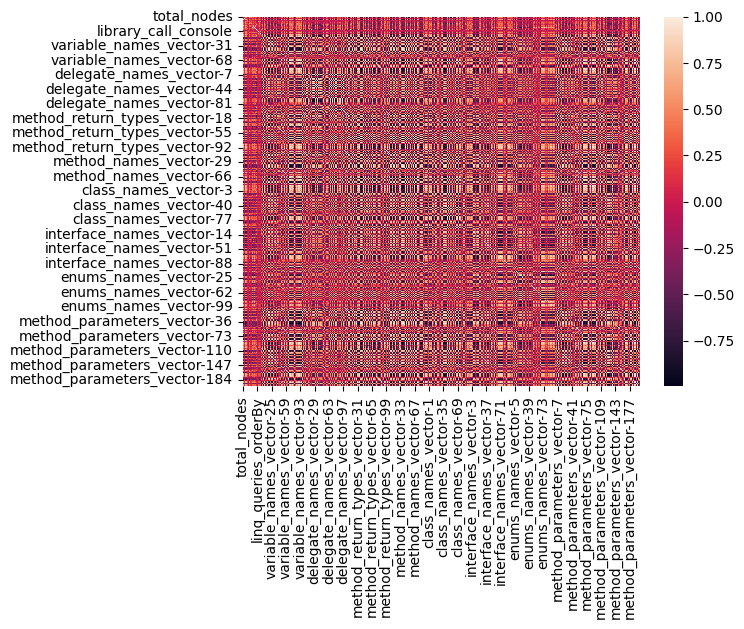

In [31]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# data = data.drop(columns=['Index1', 'Index2'])# TODO: Ubicar bien esto

# Data Normalization
scaler = StandardScaler()
important_data = data.drop(columns=['Index1', 'Index2', 'same_project'])
test_df = test_df[test_df['same_project'] == 0]
important_data_test = test_df.drop(columns=['Index1', 'Index2', 'same_project'])

scaled_test = pd.DataFrame(scaler.fit_transform(important_data_test), columns=important_data_test.columns)

scaled_data = pd.DataFrame(scaler.fit_transform(important_data), columns=important_data.columns)

# Perform correlation analysis
correlation_matrix = scaled_data.corr()

# Filtering weak correlations
threshold = 1
strong_correlations = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]

# Visualize the correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(strong_correlations, annot=True, cmap='coolwarm', fmt='.2f')
sns.heatmap(correlation_matrix)#TODO: Some values are resulting in NAN, fix this
# plt.show()

In [32]:
strong_correlations['total_nodes']

total_nodes                     1.0
max_depth                       NaN
number_of_variables             NaN
number_of_constants             NaN
out_variables                   NaN
                               ... 
method_parameters_vector-196    NaN
method_parameters_vector-197    NaN
method_parameters_vector-198    NaN
method_parameters_vector-199    NaN
method_parameters_vector-200    NaN
Name: total_nodes, Length: 942, dtype: float64

In [33]:
for feature in data.columns:
    stat, p = stats.shapiro(data[feature].dropna())
    if p > 0.05:
        print(f'{feature} is likely normally distributed (fail to reject H0)')


## One Class SVM

In [34]:
from sklearn.svm import OneClassSVM

# Assuming X_train contains your distance vectors of unique data points
X_train = scaled_data
X_test = scaled_test
# new_data = np.array([...])

# Train One-Class SVM
ocsvm = OneClassSVM(kernel='rbf', gamma='auto')
ocsvm.fit(X_train)

# Combine training and new data for visualization
# combined_data = np.vstack([X_train, new_data])

# Predict on combined data

# pred = ocsvm.predict(combined_data)
pred = ocsvm.decision_function(X_train)
# X_train = X_train.join(aux)
labels = ['Inlier' if p >= 0.5 else 'Outlier' for p in pred]

### T-SNE Dimensionality Reduction Visualization 

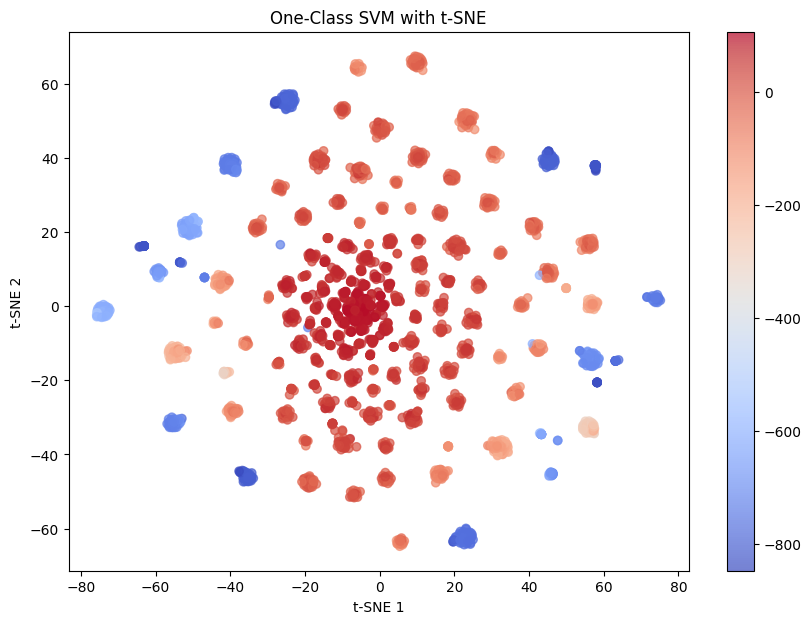

In [35]:
from sklearn.manifold import TSNE

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)

# tsne_results = tsne.fit_transform(combined_data)
tsne_results = tsne.fit_transform(X_train)

# Plot the results
plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=pred, cmap='coolwarm', alpha=0.7)
plt.title('One-Class SVM with t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar()
plt.show()

### PCA Dimensionality Redution Visualization

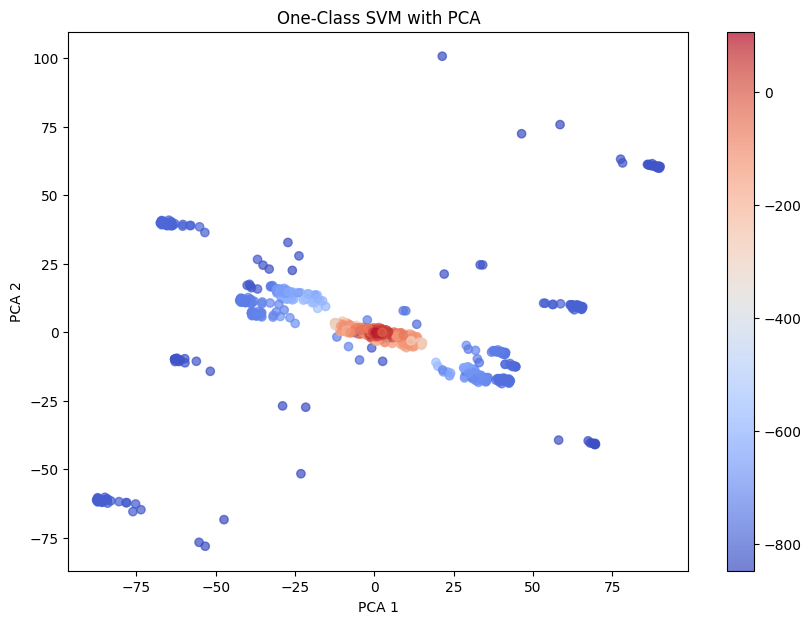

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
# pca_results = pca.fit_transform(combined_data)
pca_results = pca.fit_transform(X_train)

# Plot the results
plt.figure(figsize=(10, 7))
plt.scatter(pca_results[:, 0], pca_results[:, 1], c=pred, cmap='coolwarm', alpha=0.7)
plt.title('One-Class SVM with PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()

### Evaluating model

In [37]:
y_pred_train = ocsvm.decision_function(X_train)
y_pred_test = ocsvm.decision_function(X_test)
n_error_train = y_pred_train[y_pred_train <= -400].size
n_error_test = y_pred_test[y_pred_test <= -400].size
print(f'error train: {n_error_train}/{len(X_train)} ; errors test: {n_error_test}/{len(X_test)}')

error train: 758/3880 ; errors test: 147/712


## Isolation Forest

In [38]:
from sklearn.ensemble import IsolationForest

# Assuming X_train contains your distance vectors of unique data points
X_train = scaled_data
X_test = scaled_test
# new_data = np.array([...])

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.1)
iso_forest.fit(X_train)

# Combine training and new data for visualization
# combined_data = np.vstack([X_train, new_data])

# Predict on combined data

# pred = ocsvm.predict(combined_data)
pred = iso_forest.decision_function(X_train)
labels = ['Inlier' if p >= 0.5 else 'Outlier' for p in pred]


### T-SNE Dimensionality Reduction Visualization 

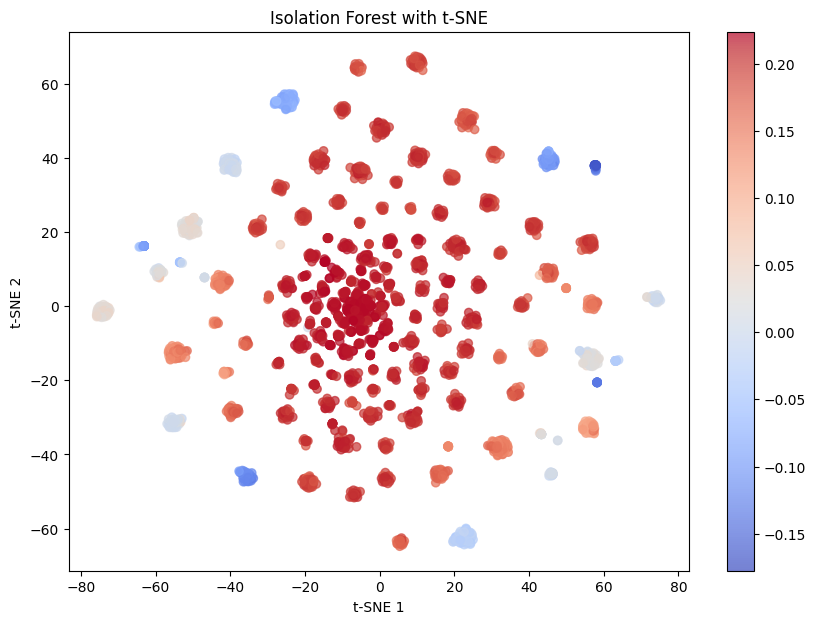

In [39]:
from sklearn.manifold import TSNE

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)

# tsne_results = tsne.fit_transform(combined_data)
tsne_results = tsne.fit_transform(X_train)

# Plot the results
plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=pred, cmap='coolwarm', alpha=0.7)
plt.title('Isolation Forest with t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar()
plt.show()

### PCA Dimensionality Redution Visualization

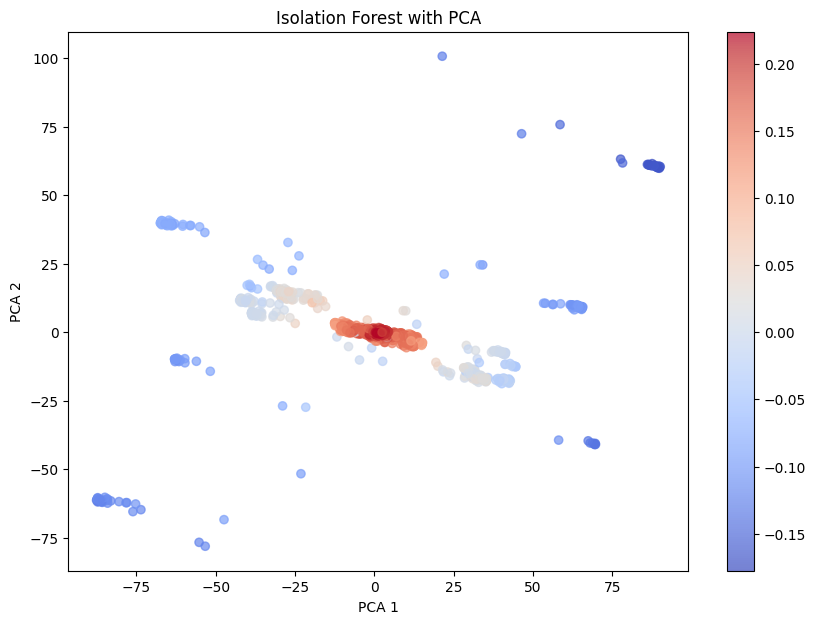

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
# pca_results = pca.fit_transform(combined_data)
pca_results = pca.fit_transform(X_train)

# Plot the results
plt.figure(figsize=(10, 7))
plt.scatter(pca_results[:, 0], pca_results[:, 1], c=pred, cmap='coolwarm', alpha=0.7)
plt.title('Isolation Forest with PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()

### Evaluating

In [41]:
y_pred_train = iso_forest.decision_function(X_train)
y_pred_test = iso_forest.decision_function(X_test)
n_error_train = y_pred_train[y_pred_train <= 0].size
n_error_test = y_pred_test[y_pred_test <= 0].size
print(f'error train: {n_error_train}/{len(X_train)} ; errors test: {n_error_test}/{len(X_test)}')

error train: 388/3880 ; errors test: 73/712


## Clustering

### K-Means

In [56]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Seleccionar columnas numéricas
numeric_data = data.select_dtypes(include=['float64', 'int64'])


# Definir el número de clusters
num_clusters = 2

# Crear y ajustar el modelo K-Means
wcss = []
for i in range(1, 300):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=1, )
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Añadir las etiquetas de los clusters al DataFrame original
# data['Cluster'] = kmeans.labels_





KeyboardInterrupt: 

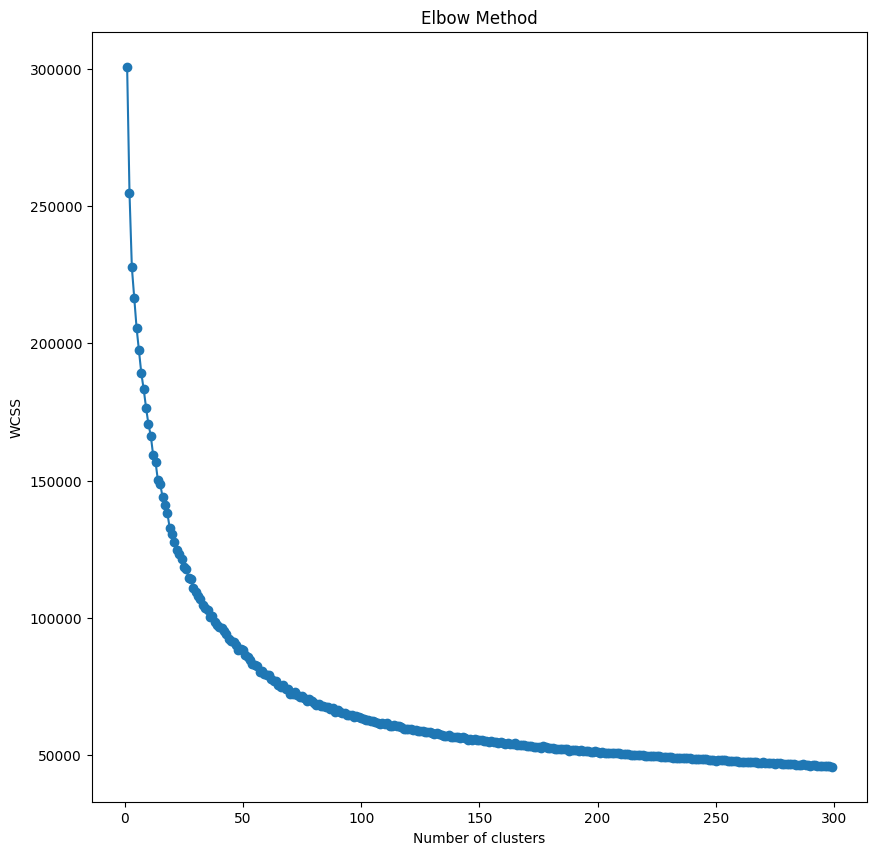

In [20]:
# Elbow method plotting
plt.figure(figsize=(10,10))
plt.plot(range(1, 300), wcss, marker = 'o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [21]:
# Create a pairplot with the specified colors
# sns.pairplot(component_wise_df, hue='Cluster', palette='tab10')
# plt.show()

### Agglomerative Clustering

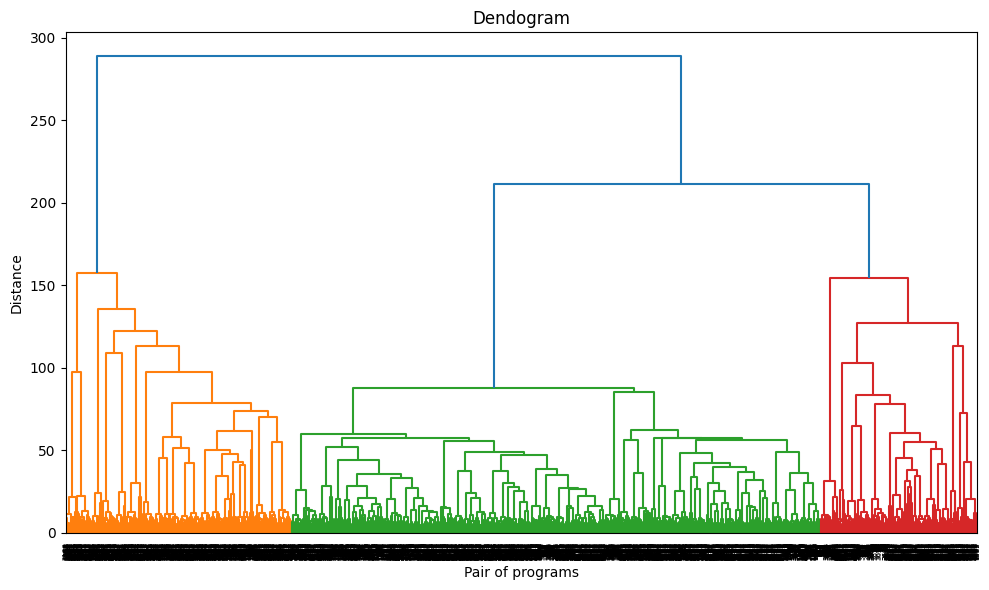

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(scaled_data, method='ward', metric='euclidean')

plt.figure(figsize=(10, 6))
dendrogram(Z, labels=data.index.values, orientation='top')
plt.title("Dendogram")
plt.xlabel("Pair of programs")
plt.ylabel("Distance")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [23]:
from sklearn.cluster import AgglomerativeClustering

cluster_ward_1 = AgglomerativeClustering(n_clusters=90, linkage='ward')# For data of differences
cluster_ward_2 = AgglomerativeClustering(n_clusters=70, linkage='ward')

# cluster_ward_1 = AgglomerativeClustering(n_clusters=50, linkage='ward')
# cluster_ward_2 = AgglomerativeClustering(n_clusters=60, linkage='ward')

y_ward_1 = cluster_ward_1.fit_predict(scaled_data)
y_ward_2 = cluster_ward_2.fit_predict(scaled_data)

data['agglomerative_ward_2'] = y_ward_2
data['agglomerative_ward_1'] = y_ward_1

In [24]:
# Create a pairplot with the specified colors
# sns.pairplot(data, hue='agglomerative_ward_2', palette='viridis')
# plt.show()

In [25]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

silhouette_avg_agg_1 = silhouette_score(scaled_data, y_ward_1)
silhouette_avg_agg_2 = silhouette_score(scaled_data, y_ward_2)

davies_bouldin_avg_agg_1 = davies_bouldin_score(scaled_data, y_ward_1)
davies_bouldin_avg_agg_2 = davies_bouldin_score(scaled_data, y_ward_2)

calinski_harabasz_avg_agg_1 = calinski_harabasz_score(scaled_data, y_ward_1)
calinski_harabasz_avg_agg_2 = calinski_harabasz_score(scaled_data, y_ward_2)

# Look for values closer to one
print(f'Silhouette Score for x clusters: {silhouette_avg_agg_1}')
print(f'Silhouette Score for y clusters: {silhouette_avg_agg_2}')

# Look for bigger values
print(f'Calinski Harabaz Score for x clusters: {calinski_harabasz_avg_agg_1}')
print(f'Calinski Harabaz Score for y clusters: {calinski_harabasz_avg_agg_2}')

# Look for smaller values
print(f'Davies Bouldin Score for x clusters: {davies_bouldin_avg_agg_1}')
print(f'Davies Bouldin Score for y clusters: {davies_bouldin_avg_agg_2}')

Silhouette Score for x clusters: 0.22361797778872816
Silhouette Score for y clusters: 0.22064031235940088
Calinski Harabaz Score for x clusters: 186.19519508550314
Calinski Harabaz Score for y clusters: 208.69435498252133
Davies Bouldin Score for x clusters: 1.4983611529303968
Davies Bouldin Score for y clusters: 1.4821405008163318
